In [3]:
# Extract song info from html
import requests
from bs4 import BeautifulSoup
billboard_url = "http://www.billboard.com/articles/list/2155531/the-hot-100-all-time-top-songs"
soup = BeautifulSoup((requests.get(billboard_url)).text, "html.parser")
songs = [song.text for song in soup.find_all("h3", {"class": "list-data__title"})]

# Extra title, artist, and year info
import re
# We consider only the first year for a song if more than one: the 100th song's case
titles  = [str(re.sub(r"\xe2\x80\xa6", r"...", re.sub("\"", "", re.match(r"\"[\"\']?.+\"[\"\']?", song).group(0)))) for song in songs]
artists = [str(re.sub("^\"|\r|(- )|(.*\".*\" )","", re.search("\" .*\r", song).group(0)).lstrip()) for song in songs]
years   = [int(re.sub("\)|\(|,", "", re.search("(\(\d{4}\))|(\(\d{4},)", song).group(0))) for song in songs]

import pandas as pd 
top100songs = pd.DataFrame({'Title': titles, 'Artist': artists, 'Year': years})

In [4]:
import requests
#import requests_cache
#requests_cache.install_cache("cache")
from bs4 import BeautifulSoup
import re
import string
import pandas as pd
test = top100songs.loc[9] 
def processString(s, type):
    s = re.sub("['?:!.,;&/]+", " ", s).lower().strip()
    if(type != "Artist"):
        s = re.sub("-", "",s)
    s = re.sub("\s+", "-", s)
    return(s)

def getLyrics(song, newUrl = ''):
    artist = song['Artist']
    title = song['Title']
    #Remove punctuation and change to lower case.
    artist = processString(artist, "Artist")
    title = processString(title," Title")
    lyric_url = "http://www.songlyrics.com/"+artist+"/"+title+"-lyrics/"
    if newUrl != '':
        lyric_url = newUrl
#    print(lyric_url)
    soup = BeautifulSoup((requests.get(lyric_url)).text, "html.parser")
    tmp = soup.find_all('p', {"id": "songLyricsDiv"})
    lyrics = tmp[0].get_text().encode("ascii","ignore")
    if bool(re.search(pattern= "(We do not have)|(we have no)", string = lyrics)):
        lyrics = ""
        lyric_url = ""
    return({'Url':lyric_url, 'Lyric': lyrics})


In [5]:
getLyrics(top100songs.loc[80])
top100songs.loc[80]

Artist                        Percy Faith
Title     The Theme from 'A Summer Place'
Year                                 1960
Name: 80, dtype: object

In [6]:
result = [getLyrics(row) for idx, row in top100songs.iterrows()]
result = pd.DataFrame(result)

In [7]:
#Locate songs that couldn't be found using function
missing =result[result['Url'] == ""].index
top100songs.loc[missing]

,Artist,Title,Year
53,Elton John,Candle in the Wind 1997 / Something About the ...,1997
60,Paul McCartney and Michael Jackson,"Say, Say, Say",1983
80,Percy Faith,The Theme from 'A Summer Place',1960
83,Jewel,You Were Meant for Me / Foolish Games,1997


In [8]:
notFoundUrls = ["http://www.songlyrics.com/elton-john-billy-joel/candle-in-the-wind-lyrics/", "http://www.songlyrics.com/percy-faith/theme-from-a-summer-place-lyrics/","http://www.songlyrics.com/jewel-feat-kelly-clarkson/foolish-games-lyrics/", ""]

In [9]:
result.loc[53,'Lyric':'Url'] = getLyrics(top100songs.loc[53], newUrl = notFoundUrls[0])
result.loc[80,'Lyric':'Url'] = getLyrics(top100songs.loc[80], newUrl = notFoundUrls[1])
result.loc[83,'Lyric':'Url'] = getLyrics(top100songs.loc[83], newUrl = notFoundUrls[2])

In [10]:
song = top100songs.loc[60]
artist = song['Artist']
title = song['Title']
lyric_url = "http://www.metrolyrics.com/say-say-say-lyrics-paul-mccartney.html"
artist = processString(artist, "Artist")
title = processString(title," Title")
soup = BeautifulSoup((requests.get(lyric_url)).text, "html.parser")
tmp = soup.find_all('div', {"id": "lyrics-body-text"})
lyrics = tmp[0].get_text().encode("ascii","ignore")
result.loc[60,'Lyric': 'Url'] = {'Lyric': lyrics, 'Url': lyric_url}

In [11]:
result = pd.concat([top100songs.reset_index(drop=True), result], axis = 1)
result.loc[53,'Title'] = "Candle in the Wind 1997"
result.loc[83, 'Title'] = "Foolish Games"

<h3>Spotify API</h3>

In [12]:
client_id = '37b4f8e242b54a67a4b8d4807b35d4aa'
client_secret = '9cb223d471b64dac9f1dc48f3b62593f'
#client_id = "Enter your client_id from spotify"
#client_secret = "Enter your client_id"

def spotify_authorize(client_id, client_secret):
    grant_type = 'client_credentials'

    #Request based on Client Credentials Flow from https://developer.spotify.com/web-api/authorization-guide/

    #Request body parameter: grant_type Value: Required. Set it to client_credentials
    body_params = {'grant_type' : grant_type}

    url='https://accounts.spotify.com/api/token'

    response=requests.post(url, data=body_params, auth = (client_id, client_secret)) 
    return(response.json())

token = spotify_authorize(client_id, client_secret)['access_token']

In [13]:
def spotify_search(term, search_type = "artist", verbose = False):
    url = "https://api.spotify.com/v1/search"
    response = requests.get(url, params = {
        "q": term,
        "type": search_type
    })
    response.raise_for_status() # check for errors
    if verbose:
        print response.url
    
    return response.json() # parse JSON

In [14]:
def spotify_audio_features(trackid, token, verbose = False):
    url = "https://api.spotify.com/v1/audio-features/"+trackid
    headers = {"Authorization":"Bearer" + ' ' + str(token)}
    response = requests.get(url, headers = headers)
    response.raise_for_status() # check for errors
    if verbose:
        print response.url

    return response.json() # parse JSON

In [15]:
def getSpotifyID(search, token):
    """
    Search for song title and artist combination on spotify and return id, duration, and other audio characteristcs
    """
    id = search['tracks']['items'][0]['id']
    length = search['tracks']['items'][0]['duration_ms']
    audio_features = spotify_audio_features(id, token)
    result = {'spotifyID': id, 
              'songLength': audio_features['duration_ms'],
              'acousticness': audio_features['acousticness'],
              'danceability': audio_features['danceability'],
              'energy': audio_features['energy'], 
              'instrumentalness': audio_features['instrumentalness'],
              'key': audio_features['key'],
              'liveness': audio_features['liveness'],
              'loudness': audio_features['loudness'],
              'mode': audio_features['mode'],
              'speechiness': audio_features['speechiness'],
              'tempo': audio_features['tempo'],
             'valence': audio_features['valence']}
    return result

In [16]:
idSearch = list()
for index, row in result.iterrows():
    search_result = spotify_search(row['Title'] + ' ' + row['Artist'], "track")
    info = getSpotifyID(search_result, token)
    idSearch.append(getSpotifyID(search_result, token))
    print info
    

{'energy': 0.639, 'tempo': 164.088, 'speechiness': 0.0539, 'instrumentalness': 0, 'key': 5, 'liveness': 0.0945, 'acousticness': 0.0359, 'songLength': 219120, 'danceability': 0.761, 'loudness': -7.577, 'valence': 0.933, 'spotifyID': u'47TqCCnEliDp8NRDyIQoQq', 'mode': 0}
{'energy': 0.638, 'tempo': 184.086, 'speechiness': 0.075, 'instrumentalness': 7.66e-05, 'key': 10, 'liveness': 0.0849, 'acousticness': 0.02, 'songLength': 250627, 'danceability': 0.378, 'loudness': -5.576, 'valence': 0.762, 'spotifyID': u'7a86XRg84qjasly9f6bPSD', 'mode': 1}
{'energy': 0.57, 'tempo': 115.376, 'speechiness': 0.0348, 'instrumentalness': 0.362, 'key': 0, 'liveness': 0.0812, 'acousticness': 0.45, 'songLength': 219933, 'danceability': 0.764, 'loudness': -11.361, 'valence': 0.972, 'spotifyID': u'6UjlpJhUqOQqv0hrb38IDI', 'mode': 1}
{'energy': 0.8, 'tempo': 93.01, 'speechiness': 0.0339, 'instrumentalness': 0, 'key': 5, 'liveness': 0.0834, 'acousticness': 0.0563, 'songLength': 219467, 'danceability': 0.71, 'loudne

In [17]:
final_data = pd.concat([result.reset_index(drop=True), pd.DataFrame(idSearch)], axis = 1)
final_data

,Artist,Title,Year,Lyric,Url,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,songLength,speechiness,spotifyID,tempo,valence
0,Usher,You Make Me Wanna...,1997,This is what you do\nThis is what you do\nThis...,http://www.songlyrics.com/usher/you-make-me-wa...,0.03590,0.761,0.6390,0.000000,5,0.0945,-7.577,0,219120,0.0539,47TqCCnEliDp8NRDyIQoQq,164.088,0.9330
1,fun. feat. Janelle Monae,We Are Young,2012,"Give me a second, I\nI need to get my story st...",http://www.songlyrics.com/fun-feat-janelle-mon...,0.02000,0.378,0.6380,0.000077,10,0.0849,-5.576,1,250627,0.0750,7a86XRg84qjasly9f6bPSD,184.086,0.7620
2,Emotions,Best of My Love,1977,Every night I'm lyin' in bed\nHoldin' you clos...,http://www.songlyrics.com/emotions/best-of-my-...,0.45000,0.764,0.5700,0.362000,0,0.0812,-11.361,1,219933,0.0348,6UjlpJhUqOQqv0hrb38IDI,115.376,0.9720
3,Maroon 5,One More Night,2012,You and I go hard at each other like we're goi...,http://www.songlyrics.com/maroon-5/one-more-ni...,0.05630,0.710,0.8000,0.000000,5,0.0834,-3.439,0,219467,0.0339,4XNrMwGx1SqP01sqkGTDmo,93.010,0.6340
4,Phil Collins,Another Day in Paradise,1989,"She calls out to the man on the street\n""Sir, ...",http://www.songlyrics.com/phil-collins/another...,0.73600,0.780,0.5650,0.002690,3,0.0630,-7.320,0,322133,0.0306,1NCuYqMc8hKMb4cpNTcJbD,101.967,0.3900
5,B.J. Thomas,Raindrops Keep Fallin' on My Head,1970,Raindrops are falling on my head\nand just lik...,http://www.songlyrics.com/b-j-thomas/raindrops...,0.81300,0.705,0.2610,0.018700,5,0.0876,-18.934,1,182667,0.0495,1KkwByi6c9dFFmUTcgMODw,108.716,0.6170
6,Puff Daddy & Faith Evans feat. 112,I'll Be Missing You,1997,Yeah... this right here (tell me why)\nGoes ou...,http://www.songlyrics.com/puff-daddy-faith-eva...,0.11100,0.833,0.6190,0.000021,7,0.1590,-5.595,1,306560,0.0538,1yy2DlSDtEt90d54rPDPXz,109.920,0.9050
7,John Cougar,Hurts So Good,1982,When I was a young boy\nSaid put away those yo...,http://www.songlyrics.com/john-cougar/hurts-so...,0.04750,0.812,0.7240,0.000045,9,0.1090,-5.321,1,218960,0.0355,67eX1ovaHyVPUinMHeUtIM,125.437,0.9690
8,Roberta Flack,Killing Me Softly With His Song,1973,Strumming my pain with his fingers\nSinging my...,http://www.songlyrics.com/roberta-flack/killin...,0.72700,0.477,0.3810,0.000000,5,0.0615,-10.237,0,286920,0.0342,3gsCAGsWr6pUm1Vy7CPPob,121.568,0.3180
9,Elvis Presley,Are You Lonesome To-Night?,1960,Are you lonesome tonight? Do you miss me tonig...,http://www.songlyrics.com/elvis-presley/are-yo...,0.81800,0.542,0.4660,0.769000,0,0.1740,-7.557,1,178200,0.0277,4XFLwpF2cgrZs0ctFume45,78.883,0.1910


<p>
<h1>Cindy's Analysis Time!! :D</h1>

In [18]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np

In [19]:
main_df = final_data
#main_df = pd.concat([top100songs,result], axis = 1)
main_df["Rank"] = range(100, 0, -1)
main_df.head()

,Artist,Title,Year,Lyric,Url,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,songLength,speechiness,spotifyID,tempo,valence,Rank
0,Usher,You Make Me Wanna...,1997,This is what you do\nThis is what you do\nThis...,http://www.songlyrics.com/usher/you-make-me-wa...,0.0359,0.761,0.639,0.000000,5,0.0945,-7.577,0,219120,0.0539,47TqCCnEliDp8NRDyIQoQq,164.088,0.933,100
1,fun. feat. Janelle Monae,We Are Young,2012,"Give me a second, I\nI need to get my story st...",http://www.songlyrics.com/fun-feat-janelle-mon...,0.0200,0.378,0.638,0.000077,10,0.0849,-5.576,1,250627,0.0750,7a86XRg84qjasly9f6bPSD,184.086,0.762,99
2,Emotions,Best of My Love,1977,Every night I'm lyin' in bed\nHoldin' you clos...,http://www.songlyrics.com/emotions/best-of-my-...,0.4500,0.764,0.570,0.362000,0,0.0812,-11.361,1,219933,0.0348,6UjlpJhUqOQqv0hrb38IDI,115.376,0.972,98
3,Maroon 5,One More Night,2012,You and I go hard at each other like we're goi...,http://www.songlyrics.com/maroon-5/one-more-ni...,0.0563,0.710,0.800,0.000000,5,0.0834,-3.439,0,219467,0.0339,4XNrMwGx1SqP01sqkGTDmo,93.010,0.634,97
4,Phil Collins,Another Day in Paradise,1989,"She calls out to the man on the street\n""Sir, ...",http://www.songlyrics.com/phil-collins/another...,0.7360,0.780,0.565,0.002690,3,0.0630,-7.320,0,322133,0.0306,1NCuYqMc8hKMb4cpNTcJbD,101.967,0.390,96


In [20]:
quant = main_df.iloc[:,7:]
del quant["spotifyID"]
del quant["Rank"]
quant["Score"] = range(1, 101)

I replaced "Rank" with "Score" to remove confusion. Now variables will be positively correlated with Score.

In [21]:
quant.head()

,energy,instrumentalness,key,liveness,loudness,mode,songLength,speechiness,tempo,valence,Score
0,0.639,0.000000,5,0.0945,-7.577,0,219120,0.0539,164.088,0.933,1
1,0.638,0.000077,10,0.0849,-5.576,1,250627,0.0750,184.086,0.762,2
2,0.570,0.362000,0,0.0812,-11.361,1,219933,0.0348,115.376,0.972,3
3,0.800,0.000000,5,0.0834,-3.439,0,219467,0.0339,93.010,0.634,4
4,0.565,0.002690,3,0.0630,-7.320,0,322133,0.0306,101.967,0.390,5


In [22]:
quant.corr()#.sort_values(by="Score", ascending = False)

,energy,instrumentalness,key,liveness,loudness,mode,songLength,speechiness,tempo,valence,Score
energy,1.000000,-0.152473,0.177549,0.115902,0.693439,-0.046899,-0.062418,0.152033,0.198912,0.441259,-0.152901
instrumentalness,-0.152473,1.000000,-0.142901,0.149550,-0.208156,0.077042,-0.123473,-0.080637,0.133926,0.152449,0.052143
key,0.177549,-0.142901,1.000000,0.148314,0.256942,-0.181065,0.070286,0.018538,0.100049,0.023161,-0.064484
liveness,0.115902,0.149550,0.148314,1.000000,-0.076383,-0.070913,-0.096029,0.159806,-0.029551,0.136866,0.099697
loudness,0.693439,-0.208156,0.256942,-0.076383,1.000000,-0.104740,-0.075373,0.040627,0.072319,0.047927,-0.216341
mode,-0.046899,0.077042,-0.181065,-0.070913,-0.104740,1.000000,0.015614,0.005364,0.110524,-0.018006,0.103928
songLength,-0.062418,-0.123473,0.070286,-0.096029,-0.075373,0.015614,1.000000,0.334186,-0.079927,-0.284108,0.021793
speechiness,0.152033,-0.080637,0.018538,0.159806,0.040627,0.005364,0.334186,1.000000,-0.119156,-0.062451,0.123102
tempo,0.198912,0.133926,0.100049,-0.029551,0.072319,0.110524,-0.079927,-0.119156,1.000000,0.241401,0.034559
valence,0.441259,0.152449,0.023161,0.136866,0.047927,-0.018006,-0.284108,-0.062451,0.241401,1.000000,-0.126271


In [23]:
# normalized
normalized = (quant - quant.mean())/quant.std()
normalized.describe()

,energy,instrumentalness,key,liveness,loudness,mode,songLength,speechiness,tempo,valence,Score
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-1.427192e-15,5.662137e-17,2.997602e-17,3.486100e-16,-3.330669e-18,3.108624e-17,-7.327472e-17,3.175238e-16,1.931788e-16,-6.661338e-18,4.440892e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.825317e+00,-2.774633e-01,-1.342153e+00,-9.345401e-01,-2.645804e+00,-1.326650e+00,-1.578460e+00,-5.563596e-01,-1.834885e+00,-1.923297e+00,-1.706220e+00
25%,-6.418450e-01,-2.774633e-01,-1.064275e+00,-5.455771e-01,-6.861396e-01,-1.326650e+00,-5.005132e-01,-4.286511e-01,-6.430517e-01,-7.496873e-01,-8.531102e-01
50%,5.315178e-02,-2.774521e-01,4.723935e-02,-3.372663e-01,9.763023e-02,7.462406e-01,-1.622311e-01,-3.425415e-01,-5.140209e-02,7.669413e-02,0.000000e+00
75%,7.945755e-01,-2.750622e-01,8.808749e-01,1.385412e-01,7.437691e-01,7.462406e-01,3.820501e-01,-5.426153e-02,3.748685e-01,9.132664e-01,8.531102e-01
max,1.758286e+00,5.466479e+00,1.714510e+00,6.300829e+00,1.793753e+00,7.462406e-01,6.019638e+00,6.527091e+00,2.910983e+00,1.401499e+00,1.706220e+00


From the correlation matrix, we can see that the strongest correlators with "Rank" are speechiness, mode, and liveness. However, the correlation is very weak, indicating that many may be coincidental.

In [24]:
print " + ".join(list(quant)[0:10])

energy + instrumentalness + key + liveness + loudness + mode + songLength + speechiness + tempo + valence


We can see that the regression is not very strong from this model. We cannot come to any conclusion based on these results. This can be due to our limited sample size, especially since the simple is not identical. Each song is unique and a bit hit during a time period. They must each have their own characteristics and cannot be judged based off other top hits. 
<p>If we had a larger data set with good and bad songs (a nice variety), preferably from the same time period, then there may be different results.

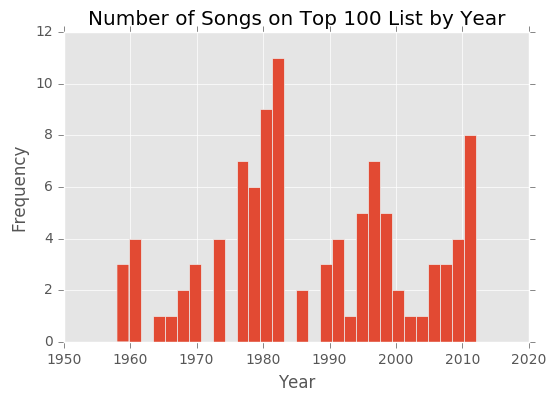

In [26]:
plt.hist(main_df["Year"], bins = 30)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Number of Songs on Top 100 List by Year")
plt.show()

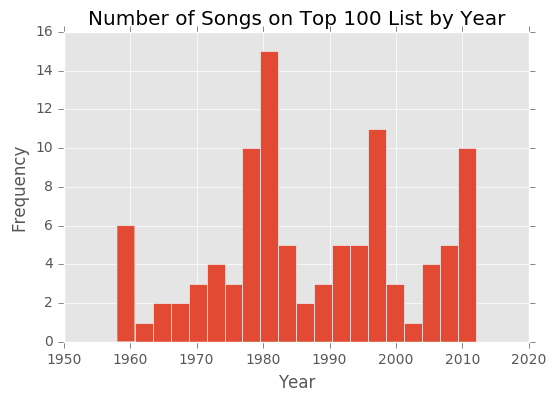

In [27]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.hist(main_df["Year"], bins = 20)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Number of Songs on Top 100 List by Year")
plt.show()

In [28]:
max(main_df["Year"]), min(main_df["Year"])

(2012, 1958)

From the histogram, we can see there were quite a lot of top hits right when the first official 'blended' billboard began in 1958. After there, it is not until the late 1970's that music really picks up again. The all-time peak is in that time frame (late 1970s to early 1980s).
<p>After that, there is a dip with normal amounts of top hits until the late 1990s, with another spike. This spike is soon followed by a big dip, which picks up again in the in the later half of the 2000s.
<p>We can see that the 2010's are starting strong with lots of top hits coming out.

<i>Some questions to think about:
* Could the peak in the 2010s be attributed to the fact that music was much more easily distributed at that time? Is this Billboard chart a good measure of popularity?
* Are we able to pinpoint major trends and music phases?
* Are the frequencies also in line with the song's absolute performance on the chart?
* Why were there not that many hits in the early 2000s? Was this just a simple music low, was it due to external factors, or was it simply because one song hit the charts for a long time?
* What were the songs and rankings from the late 1970s-early 1980s?

<i>Note: The first question is simply to add a bit of skepticism and will not be explored in this project.</i>

In [29]:
peak_70_80 = main_df[(main_df["Year"] > 1975) & (main_df["Year"] < 1984)].sort_values(by="Rank")
peak_70_80.head()

,Artist,Title,Year,Lyric,Url,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,songLength,speechiness,spotifyID,tempo,valence,Rank
92,Olivia Newton-John,Physical,1981,I'm saying all the things that I know you'll l...,http://www.songlyrics.com/olivia-newton-john/p...,0.0728,0.839,0.633,0.000031,4,0.3100,-11.353,0,224773,0.0445,3hVrI7snZMTmHCnbwME47u,123.816,0.8470,8
91,Debby Boone,You Light Up My Life,1977,So many nights I'd sit by my window\nWaiting f...,http://www.songlyrics.com/debby-boone/you-ligh...,0.8550,0.322,0.282,0.000010,2,0.1630,-12.516,1,218933,0.0301,7yjAL13BeIaT9BKJZBy8b1,77.470,0.0786,9
86,Kim Carnes,Bette Davis Eyes,1981,Her hair is Harlow gold\nHer lips sweet surpri...,http://www.songlyrics.com/kim-carnes/bette-dav...,0.0204,0.675,0.649,0.000000,5,0.0959,-10.271,1,228000,0.0319,0odIT9B9BvOCnXfS0e4lB5,116.624,0.5940,14
85,Diana Ross & Lionel Richie,Endless Love,1981,My love\nThere's only you in my life\nThe only...,http://www.songlyrics.com/diana-ross-lionel-ri...,0.7780,0.437,0.354,0.000046,10,0.1560,-13.657,1,267587,0.0271,2Y2qBdSI1GwmN7CnkNul7j,93.147,0.2390,15
84,Rod Stewart,Tonight's the Night (Gonna Be Alright),1976,Stay away from my window\nStay away from my ba...,http://www.songlyrics.com/rod-stewart/tonight-...,0.3360,0.550,0.514,0.125000,11,0.3820,-12.617,1,237120,0.0523,10LRRKPmx8uHcSxLVWK0ct,136.542,0.7090,16


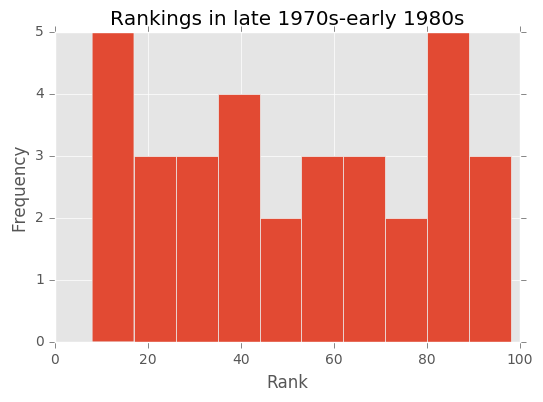

In [30]:
plt.hist(peak_70_80["Rank"], bins = 10)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Rankings in late 1970s-early 1980s")
plt.show()

This answers the last question. We can see that there is not a noticeable skew in the data. This could mean that yes, there were a lot of all-time popular songs during these eras, and these songs performed typically like how the rest of the distribution, with roughly even numbers throughout. We <b>cannot</b> say that 
* <i>Hypothesis 1:</i> The songs from this era had high quantity but had very mediocre/lower ranked songs (quantity > quality), nor the opposite --
* <i>Hypothesis 2:</i> America went through a music revolution and released a bunch of top hit singles of all time during this period.

<h2>Frequencies and Popularities</h2>
<p>Now I will try to create a modified plot to capture frequencies, balanced with the Billboard rank performance.

In [31]:
freqs = main_df["Year"].value_counts()
freqs.head()

1982    6
1980    5
1983    5
1997    5
2012    4
Name: Year, dtype: int64

In [32]:
rank_boost = np.arange(1, 101)
rank_boost = rank_boost * 0.10
rank_boost[95:]

array([  9.6,   9.7,   9.8,   9.9,  10. ])

In [33]:
frq_df = pd.concat([main_df["Year"], pd.Series(rank_boost)], axis = 1)
frq_df.head()

,Year,0
0,1997,0.1
1,2012,0.2
2,1977,0.3
3,2012,0.4
4,1989,0.5


In [34]:
unique_years = frq_df["Year"].unique()
sum_boosts = {}

for year in frq_df["Year"].unique():
    entries = frq_df[frq_df["Year"] == year]
    sum_boosts[year] = sum(entries.iloc[:,1])

asd = pd.DataFrame(sum_boosts.items(), columns=['Year', 'Boost Value'])
asd.head()

,Year,Boost Value
0,1958,5.8
1,1959,16.6
2,1960,19.1
3,1961,6.9
4,1964,5.7


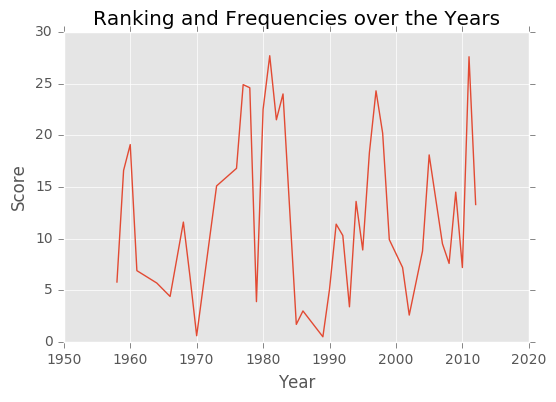

In [35]:
plt.plot(asd["Year"], asd["Boost Value"], '-')
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("Ranking and Frequencies over the Years")
plt.show()

<p><h2>Artists</h2>

In [36]:
# number of unique artists
len(main_df["Artist"].unique())

93

In [37]:
main_df["Artist"].value_counts().head(10)

Bee Gees                                 2
Boyz II Men                              2
Lionel Richie                            2
The Beatles                              2
The Black Eyed Peas                      2
Marvin Gaye                              2
Andy Gibb                                2
Olivia Newton-John                       1
Diana Ross                               1
LMFAO feat. Lauren Bennett & GoonRock    1
Name: Artist, dtype: int64

There are not many duplicate entries by artists on this ultimate 100 list. The maximum repeat by an artist is 2. There are only 7 repeat artists.